In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import math as mt
import glob
import pandas as pd
from matplotlib.pyplot import figure
import random
from networkx.algorithms.distance_measures import center
from networkx.algorithms import community

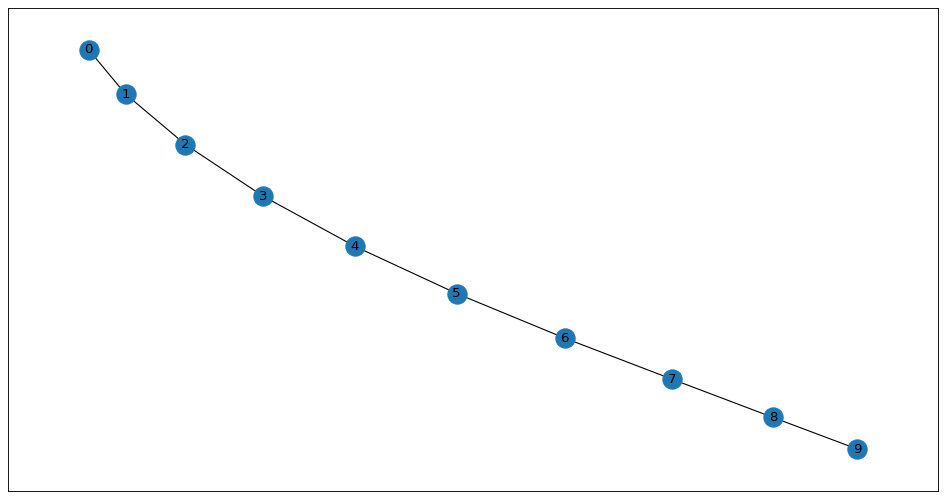

In [2]:
#g = nx.read_edgelist("../DATA/Tree/tree90_3.txt")
g= nx.path_graph(10)
#g = nx.read_adjlist("power.txt", nodetype=int)
#g.nodes()
figure(figsize=(15, 8), dpi=80)
nx.draw_networkx(g)
plt.show()
#path=nx.shortest_path(g)
#print(path[9][20])
#g = nx.ego_graph(g, 6, radius=2)
#list(g.nodes())

In [3]:
def read_graph(file):
    G = nx.Graph()
    with open(file, "r") as file1:
        s = file1.read().split("\n")
        k = s[0].split(" ")
        V = int(k[1])
        E = int(k[0])
        i = -1
        for i in range(1,E+1):
            k = s[i].split(" ")
            G.add_edge(int(k[0]),int(k[1]))
            #print(k)
        for j in range(1,V+1):
            k = s[i+j].split(" ")
            #G.add_edge(int(k[0]),int(k[1]))
            G.nodes[int(k[0])]['weight']=float(k[1])
            #print(k)
    return G

In [4]:
def interest_and_thresold(g):
    I   = {}
    T   = {}
    IS  = {}
    A   = {}
    for u in g.nodes():
        T[u]   = mt.ceil(0.5*len([n for n in g.neighbors(u)]))
        IS[u]  = 0
        I[u]   = g.nodes[u]['weight']
        A[u]   = 0
    return I,T,A,IS

In [5]:
def diffusion_function(g,u,D,SR,AW,I):
    m = 0
    L = []
    SR[u] = 1
    L.append(u)
    if AW[u]==0:
        AW[u] = 1
        m     = m + I[u]
    while len(L)!=0:
        v = L.pop(0)
        for i in g.neighbors(v):
            if AW[i]==0:
                AW[i] = 1
                m     = m + I[i]
            D[i] = D[i] - 1
            if D[i]<=0 and SR[i]==0:
                SR[i] = 1
                L.append(i)
    return AW,SR,D,m

In [6]:
def diffusion_function_fin(g,D,SR,AW,I):
    m = 0
    L = []
    #SR[u] = 1
    for v in SR.keys():
        if SR[v]==1:
            L.append(v)
            if AW[v]==0:
                AW[v] = 1
                m     = m + I[v]
    while len(L)!=0:
        v = L.pop()
        for i in g.neighbors(v):
            if AW[i]==0:
                AW[i] = 1
                m     = m + I[i]
            D[i] = D[i] - 1
            if D[i]<=0 and SR[i]==0:
                SR[i] = 1
                L.append(i)
    return AW,SR,D,m

In [7]:
def spreaders(g,K,budget):
    I,T,A,IS = interest_and_thresold(g)
    #print(I,T,K,A,IS)
    bgt = budget
    S = set() # seed set 
    while(budget>0):
        mx  = 0
        A_  = -1
        IS_ = -1
        T_  = -1
        v_  = -1
        for u in K:
            if IS[u]!=0:
                continue
            aw,sr,t,m = diffusion_function(g,u,T.copy(),IS.copy(),A.copy(),I)
            #print("m = ", m, "v= ",u)
            if mx < m:
                mx  = m
                A_  = aw
                IS_ = sr
                T_  = t
                v_  = u
        if v_ != -1:
            A  = A_
            IS = IS_
            T  = T_
            #print(v_)
            #print(m)
            S.add(v_)
        budget = budget - 1
    #for i in g.neighbors(85):
        #print("-",i, A[i])
    _,T,A,IS = interest_and_thresold(g)
    for u in S:
        IS[u] = 1
    aw,sr,t,m = diffusion_function_fin(g,T,IS,A,I)
    print("Max interst : ",m,bgt)
    return m,A

In [8]:
def do_refine(S,g,A):
    I,T,A,IS = interest_and_thresold(g)
    flag = True
    no = 0
    #print("size of seed set : ", len(S.keys()))
    while flag:
        flag = False
        for i in S:
            l = 0
            for j in [n for n in g.neighbors(i)]:
                if j in S:
                    l = l + 1
            if l >= T[i]:
                flag = True
                S.remove(i)
                #print("removed one")
                no = no + 1
                break
    #print("number of removal took place ! ", no)
    
    return S,no

In [28]:
def independent_c_model(G,u,S,A,I): 
    #print(f'for {u}')
    k = 0
    jst_inf  = {}
    infected = {}
    for i in G.nodes():
        infected[i] = 0
        if A[i]==1:
            infected[i] = 1
        
    s    = []
    S[u] = 1
    jst_inf[u]  = 1
    for u in S.keys():
        if S[u]==1:
            infected[u] = 1
            k = k+1
        
    m = 0 
    while(1):
        if len(jst_inf.keys())==0:
            for u in infected.keys():
                if infected[u]==1 and A[u]==0:
                    m = m + I[u]
                    A[u] = 1
            #print("Exited ID MODEL with m = ",m )
            #print("infected nodes : ", k)
            return A,A,0,m
        tmp = []
        #print(len(jst_inf))
        for each in jst_inf.keys():
            for each_1 in G.neighbors(each):
                r = random.uniform(0,1)
                #print(r)
                if r < 0.5*I[each] and infected[each_1]==0 and (each_1 not in tmp):
                    tmp.append(each_1)
        jst_inf  = {}
        for each in tmp:
            infected[each] = 1
            k = k+1
            jst_inf[each]  = 1

In [11]:
def is_awr2(g,u,D,SR,AW,I):
    m = 0
    L = []
    #S = S.union(S1)
    SR[u] = 1
    L.append(u)
    if AW[u]==0:
        AW[u] = 1
        m     = m + I[u]
    while len(L)!=0:
        v = L.pop(0)
        for i in g.neighbors(v):
            if AW[i]==0:
                AW[i] = 1
                m     = m + I[i]
            D[i] = D[i] - 1
            if D[i]<=0 and SR[i]==0:
                SR[i] = 1
                L.append(i)
    return AW,SR,D,m

def spr(g,K,GL,bgt):
    #A  = {}
    S  = set()
    SF = set()
    I,T,A,SR = interest_and_thresold(g)
    LK = 0
    sm = 0
    opt = []
    for v in K:
        sf = SF.copy()
        if SR[v]==1 or A[v]==1:
            continue            
        sf.add(v)
        #print("called to - > ",v)
        #a,S  = is_awr(g,sf.copy(),T,a,v)
        #awr,sr,T1,lk  = is_awr2(g,v,T.copy(),SR.copy(),AWR.copy(),I)
        awr,sr,T1,lk = independent_c_model(g,v,SR.copy(),A.copy(),I)
        if lk>0:
            #print("added",v)
            LK = LK + lk
            sm = sm + 1
            #print("!awared length till now :",LK,sm)
            #print("SP length! ",len(S))
            SF   = sf.copy()
            A    = awr.copy()
            SR   = sr.copy()
            bgt  = bgt - 1
            if bgt%10==0:
                opt.append(round(LK,1))
                #print(LK)
            if bgt==0:
                break
        #break
    #print("len : seed set ", len(SF), sum(AWR.values()), bgt)
    #SF,n = do_refine(SF,g,AWR)
    
    if len(opt)==0:
        opt.append(LK)
            

    
    while len(opt)<10:
        opt.append(round(LK,1))
    print("Max interst : ",LK)
    return opt
#/home/rkg/Dropbox/D&C/PY_CODE/PA/BuzzNet-dataset/buzznet

In [12]:
def multi_BFS(K,g):
        L = []
        V = {}
        Main_list = []
        for u in g.nodes():
            V[u] = 0
        for u in K:
            L.append(u)
            Main_list.append(u)
            V[u] = 1
        m = 0
        while len(L)!=0:
            u = L.pop(0)
            m = m + 1
            if len(K)*2<m:
                break
            for i in g.neighbors(u):
                if V[i]==0:
                    V[i] = 1
                    L.append(i)
                    Main_list.append(i)
        return Main_list

In [13]:
def want_dictionary_sorted(D,ls):
    D1 = {}
    for u in ls:
        D1[u] = D[u]
    l   = [k for k, v in sorted(D1.items(), key=lambda item: item[1])]
    l.reverse()
    return l

In [14]:
def level_vise_vertices(lst,g_):
    lv = {}
    tnd = set()
    for u in lst:
        tnd.add(u)
    for i in range(1,1000):
        s  = set()
        g1 = nx.ego_graph(g_, lst[0], radius=i, center=True, undirected=True, distance=None)
        lv[i] = []
        flag = False
        for u in g1.nodes():
            if u not in tnd:
                lv[i].append(u)
                tnd.add(u)
                #print("for i = ", i)
                flag = True
        if flag == False:
            del lv[i]
            break
    return lv

In [15]:
def vertical_list(rg,lv,D):
    m_list = []
    f = True
    while f:
        f = False
        tl = []
        for i in rg:
            if lv[i]:
                u = lv[i].pop(0)
                tl.append(u)
                f = True
        if f:
            tl = want_dictionary_sorted(D,tl)
            for i in tl[0:mt.floor(len(tl))]:
                m_list.append(i)
    return m_list    

In [16]:
def update_graph_get_list(g,K):
    g_ = g.copy()
    #center = K[0]
    n = mt.floor(gl*0.5)
    #print("N= ",n)
    D = dict(g.degree())
    m_list = []
    lst = []
    for i in range(n):
        lst.append(K[i])
    #lst.append(center)
    lv = level_vise_vertices(lst,g)
    #print("len : lst ", len(lst))
    #level wise vertices will be stored in lv 
    lv[0] = lst
    rg  = list(lv.keys())
    rg.sort()
    #print("RG : ",rg)
    for k in rg:
        lv[k] = want_dictionary_sorted(D,lv[k])
        #print("level = ", k, "items", len(lv[k]))
    #print(len(lv[0]))
    m_list = vertical_list(rg,lv,D)
    for u in g.nodes():
        if u not in m_list:
            m_list.append(u)
    return m_list

In [17]:
def max_interest_algo_1(g,ls,gl,bgt):
    bg = bgt
    #print("length list", len(ls))
    return spr(g,ls,gl,bg)

In [18]:
def max_interest_algo_2(g,gl,bgt,K):
    m  = 0
    ls1 = []
    bg = bgt
    D = dict(g.degree())
    #D = nx.pagerank(g, alpha=0.9)
    #print(D)
    #K = [k for k, v in sorted(D.items(), key=lambda item: item[1])]
    #K =  list(reversed(K))
    ls  = [k for k, v in sorted(D.items(), key=lambda item: item[1])]
    ls.reverse()
    return spr(g,ls,gl,bg)
    #ls.reverse()

In [19]:
def benifits_of(g,I,A):
    I_ = {}
    for u in g.nodes():
        if A[u]==1:
            continue
        I_[u] = I[u]
        for v in g.neighbors(u):
            if A[v]==0:
                I_[u] = I[v] + I_[u]
    return [k for k, v in sorted(I_.items(), key=lambda item: item[1])]

In [20]:
def max_interest_algo_3(g,bgt):
    S = set()
    opt = [] 
    I,T,A,IS = interest_and_thresold(g)
    mt = 0 
    #print(I)
    for i in range(bgt):
        K = benifits_of(g,I,A)
        #print(len(K))
        if len(K)==0:
            opt.append(round(mt,1))
            break
        #print(I)
        #if A[K[-1]]==1:
            #continue
            
        #IS[K[-1]] = 1
        S.add(K[-1])
        #I[K[-1]]  = 0
        #print("added : ", K[-1],I[K[-1]])
        A,SR,D,m = independent_c_model(g,K[-1],IS.copy(),A.copy(),I)
        mt = mt + m
        #print(mt)
        #AW,SR,D,m = diffusion_function_fin(g,T.copy(),IS.copy(),A.copy(),I)
        if (i+1)%10==0:
            opt.append(round(mt,1))
        
    #print(S)
    #I,T,A,IS = interest_and_thresold(g)
    #for u in S:
        #IS[u] = 1
    #aw,sr,t,m = diffusion_function_fin(g,T,IS,A,I)
    #print(opt)
    while len(opt)<10:
        opt.append(round(mt,1))
    return opt

In [33]:
start = 100
end   = 110
gap   = 10
keys = [x for x in range(10,110,10)]
#print(keys)
keys.insert(0,"name")
#print(keys)
data = []
for file in glob.glob("../DATA/*.txt"):
    drow = []
    print("Name : ", file)
    drow.append(file)
    g  = read_graph(file)
    #eg = nx.eigenvector_centrality(g, max_iter=100000)
    #print(len(g.edges())/len(g.nodes()))
    I,T,A,IS = interest_and_thresold(g)
    #print(I)
    s = 0
    for i in I.keys():
        s = s + I[i]
        
    print("Total interest : ", s )
    gl  = len(g.nodes())
    #print("is connected : ", nx.is_connected(g))
    print("graph size :  ",gl)
    #d = dict(nx.degree(g))
    #K   = [k for k, v in sorted(d.items(), key=lambda item: item[1])]
    K   = [k for k, v in sorted(I.items(), key=lambda item: item[1])]
    K =  list(reversed(K))
    for bgt in range(start,end,gap):
        ls  = update_graph_get_list(g,K)
        #print("len LS : ", len(ls))
        ##ls.reverse()
        #print("length of list : ", len(ls), "for", bgt)
        m1 = max_interest_algo_1(g,ls,gl,bgt)
        #m2 = max_interest_algo_2(g,gl,bgt,K)
        #print("m1 = ",m1 , "m2 = ", m2)
        #print("*****- >","progress")
        #m3  = max_interest_algo_3(g,bgt)
        drow.extend(m1)
        print(".", end="")
        #break
    print()
    print(drow)
    data.append(drow)
    #break
    #m2 = max_interest_updated(g,gl,bgt,K)
    #print("m1 = ",m1 , "m2 = ", m2)
    #figure(figsize=(15, 8), dpi=80)
    #nx.draw_networkx(H)
    #plt.show()

Name :  ../DATA/power.txt
Total interest :  2478.987963140242
graph size :   4941
Max interst :  115.20366910591905
.
['../DATA/power.txt', 35.4, 38.4, 42.2, 57.8, 84.8, 88.2, 92.7, 104.9, 109.1, 115.2]
Name :  ../DATA/BlogCatalog3.txt
Total interest :  5193.66722676599
graph size :   10312
Max interst :  4729.332824894079
.
['../DATA/BlogCatalog3.txt', 4707.8, 4710.5, 4713.1, 4715.1, 4718.1, 4721.0, 4722.6, 4725.3, 4726.8, 4729.3]
Name :  ../DATA/CA-HepTh.txt
Total interest :  4917.828837411633
graph size :   9877
Max interst :  1935.777684799407
.
['../DATA/CA-HepTh.txt', 1857.2, 1861.9, 1881.3, 1886.7, 1888.9, 1894.9, 1916.6, 1922.5, 1927.9, 1935.8]
Name :  ../DATA/facebook_combined.txt
Total interest :  1987.5242580525671
graph size :   4039
Max interst :  1855.4718035096012
.
['../DATA/facebook_combined.txt', 1822.7, 1834.3, 1836.2, 1837.9, 1841.0, 1843.6, 1847.9, 1850.4, 1853.2, 1855.5]
Name :  ../DATA/CA-GrQc.txt
Total interest :  2603.995045176847
graph size :   5242
Max inters

In [34]:
df = pd.DataFrame(data, columns=keys)
df.to_csv("Results/algo1-IND_1.csv")
df

,name,10,20,30,40,50,60,70,80,90,100
0,../DATA/power.txt,35.4,38.4,42.2,57.8,84.8,88.2,92.7,104.9,109.1,115.2
1,../DATA/BlogCatalog3.txt,4707.8,4710.5,4713.1,4715.1,4718.1,4721.0,4722.6,4725.3,4726.8,4729.3
2,../DATA/CA-HepTh.txt,1857.2,1861.9,1881.3,1886.7,1888.9,1894.9,1916.6,1922.5,1927.9,1935.8
3,../DATA/facebook_combined.txt,1822.7,1834.3,1836.2,1837.9,1841.0,1843.6,1847.9,1850.4,1853.2,1855.5
4,../DATA/CA-GrQc.txt,864.3,920.8,945.6,962.3,985.7,1003.0,1028.7,1051.9,1071.2,1094.8
5,../DATA/CA-HepPh.txt,3551.3,3553.3,3555.7,3574.8,3577.6,3586.7,3597.2,3603.8,3607.8,3611.9


In [510]:
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Name', 'Age'])

In [511]:
df

,Name,Age
0,tom,10
1,nick,15
2,juli,14
